In [20]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In this demo, we try to solve a two dimensional XOR classification problem with a 4-hidden-layer fully connected NN whose hidden layers are also two dimensional. 

We examine the mutual information between representaion of layers with input/output as well as the dimension of the representation during the training process. 

Reference:
- Opening the Black Box of Deep Neural Networks via Information (Ravid Shwartz-Ziv, Naftali Tishby 2017)
- Interactions between Intrinsic and Stimulus-Evoked Activity in Recurrent Neural Networks (Larry F. Abbott, Kanaka Rajan, Haim Sompolinsky 2011)
    -- The dimension definition comes from the above paper
    

In [15]:
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

In [2]:
ctx = mx.gpu(0)

In [3]:
# generate 2 classes of balanced data on 2D grid plane
def gen_data(ngrid = 4, ndata=10, plot=True, ctx=ctx):
    Axs = np.random.choice(range(ngrid), ngrid**2/2)
    Ays = np.random.choice(range(ngrid), ngrid**2/2)
    grid_width = 1.0/ngrid
    while len(set(zip(Axs, Ays))) < ngrid**2/2:
        Axs = np.r_[Axs, np.random.choice(range(ngrid), 1)]
        Ays = np.r_[Ays, np.random.choice(range(ngrid), 1)]

    X = nd.zeros([ndata, 2], ctx=ctx)
    Y = nd.zeros([ndata,], ctx=ctx)
    for n in range(ndata):
        val = np.random.uniform(size=2)
        X[n, :] = val
        pxid, pyid = np.floor(val/grid_width)
        for x, y in zip(Axs, Ays):
            if int(pxid) == x and int(pyid) == y:
                Y[n] = 1
    if plot:
        plt.figure()
        colors=['r','b']
        for n in range(ndata):
            plt.plot(X.asnumpy()[n,0], X.asnumpy()[n,1],'o', color=colors[int(Y.asnumpy()[n])])
    return X, Y

We generate two dimensional inputs with labels red and blue. In the following, we trained a four layer fully connected network to classify these points. 

<IPython.core.display.Javascript object>


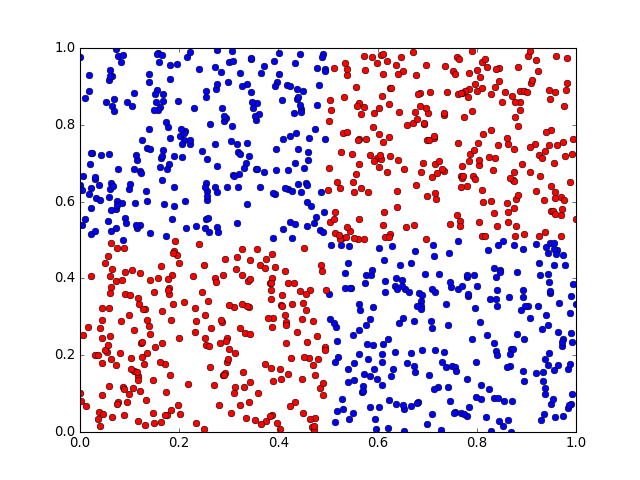

In [13]:
np.random.seed(4)
X, Y = gen_data(ngrid=2, ndata=1000, plot=1, ctx=ctx)

Here is the network structure.

In [19]:
net

Sequential(
  (0): Dense(2, Activation(tanh))
  (1): Dense(2, Activation(tanh))
  (2): Dense(2, Activation(tanh))
  (3): Dense(2, Activation(tanh))
)

In [14]:
# calculate mutual information between X and Y
def mutual_info_XY(X, Y, lbX=0.0, ubX=1.0, ngridX=2):
    cnts = np.zeros([ngridX+1, ngridX+1, 2])
    grid_width = (ubX - lbX) / ngridX
    for i in range(len(Y)):
        x,y = X[i, :]
        xpos = int(np.floor((x-lbX)/grid_width))
        ypos = int(np.floor((y-lbX)/grid_width))
        zpos = int(Y[i])
        cnts[xpos, ypos, zpos] += 1

    MI = 0
    cntsX = np.sum(cnts, axis=2)
    cntsY = np.sum(cnts, axis=(0,1))
    cntsall = np.sum(cntsY)
    for i in range(cnts.shape[0]):
        for j in range(cnts.shape[1]):
            for k in range(cnts.shape[2]):
                Pxy = 1.0*cnts[i,j,k]/cntsall
                Px = 1.0*cntsX[i,j]/cntsall
                Py = 1.0*cntsY[k]/cntsall
                if abs(Pxy/Px/Py)>1e-3:
                    MI += Pxy * np.log(Pxy/Px/Py)
    return MI
    
def mutual_info_XT(X, T, lbX=0.0, ubX=1.0, lbT=-1.0, ubT=1.0, ngridX=2, ngridT=2):
    cnts = np.zeros([ngridX+1, ngridX+1, ngridT+1, ngridT+1])
    gridX_width = (ubX - lbX) / ngridX
    gridT_width = (ubT - lbT) / ngridT
    for i in range(len(X)):
        x,y = X[i, :]
        xpos = int(np.floor((x-lbX)/gridX_width))
        ypos = int(np.floor((y-lbX)/gridX_width))
        z,w = T[i, :]
        zpos = int(np.floor((z-lbT)/gridT_width))
        wpos = int(np.floor((w-lbT)/gridT_width))
        cnts[xpos, ypos, zpos, wpos] += 1

    MI = 0
    cntsX = np.sum(cnts, axis=(2,3))
    cntsT = np.sum(cnts, axis=(0,1))
    cntsall = np.sum(cntsX, axis=(0,1))
    for i in range(cnts.shape[0]):
        for j in range(cnts.shape[1]):
            for k in range(cnts.shape[2]):
                for l in range(cnts.shape[3]):
                    Pxy = 1.0*cnts[i,j,k,l]/cntsall
                    Px = 1.0*cntsX[i,j]/cntsall
                    Py = 1.0*cntsT[k,l]/cntsall
                    if abs(Pxy/Px/Py)>1e-10:
                        MI += Pxy * np.log(Pxy/Px/Py)
    return MI
    
def calc_current_mi(net, X, Y, ngridX=2, ngridT=100):
    XTs = np.zeros([4,])
    YTs = np.zeros([4,])
    XTs[0] = mutual_info_XT(X.asnumpy(), net[0](X).asnumpy(), ngridX=ngridX, ngridT=ngridT)
    XTs[1] = mutual_info_XT(X.asnumpy(), net[1](net[0](X)).asnumpy(), ngridX=ngridX, ngridT=ngridT)
    XTs[2] = mutual_info_XT(X.asnumpy(), net[2](net[1](net[0](X))).asnumpy(), ngridX=ngridX, ngridT=ngridT)
    XTs[3] = mutual_info_XT(X.asnumpy(), net(X).asnumpy(),ngridX=ngridX, ngridT=ngridT)
    
    YTs[0] = mutual_info_XY(net[0](X).asnumpy(), Y.asnumpy(), lbX=-1.0, ubX=1.0, ngridX=ngridT)
    YTs[1] = mutual_info_XY(net[1](net[0](X)).asnumpy(), Y.asnumpy(), lbX=-1.0, ubX=1.0, ngridX=ngridT)
    YTs[2] = mutual_info_XY(net[2](net[1](net[0](X))).asnumpy(), Y.asnumpy(), lbX=-1.0, ubX=1.0, ngridX=ngridT)
    YTs[3] = mutual_info_XY(net(X).asnumpy(), Y.asnumpy(), lbX=-1.0, ubX=1.0, ngridX=ngridT)
    return XTs, YTs

In [6]:
from numpy.linalg import svd
def dimension(X):
    X = X - np.mean(X, axis=0)
    u,s,v = svd(X, full_matrices=0)
    return np.sum(s)**2 / np.sum(s**2)

def plot(X, Y, ax):
    colors=['r','b']
    X1 = []
    Y1 = []
    X2 = []
    Y2 = []
    for n in range(len(Y)):
        if Y.asnumpy()[n] == 0:
            X1.append(X.asnumpy()[n, 0])
            Y1.append(X.asnumpy()[n, 1])
        else:
            X2.append(X.asnumpy()[n, 0])
            Y2.append(X.asnumpy()[n, 1])
            
    for n in range(len(Y)):
        ax[0].plot(X.asnumpy()[n,0], X.asnumpy()[n,1],'o',markerfacecolor="None",
         markeredgecolor=colors[int(Y.asnumpy()[n])], markeredgewidth=1)
    ax[1].hist2d(X1, Y1, normed=1,cmap='Reds')
    ax[2].hist2d(X2, Y2, normed=1, cmap='Blues')
    
def plot_feature_map(net, X, Y, e):
    f, ax = plt.subplots(3,4, figsize=(14,4))
    
    plot(net[0](X), Y, ax[:,0])
    ax[0,0].set_title('epoch %d,layer 0,dim %.2f' % (e, dimension(net[0](X).asnumpy()) ))
    plot(net[1](net[0](X)), Y, ax[:,1])
    ax[0,1].set_title('epoch %d,layer 1,dim %.2f' % (e, dimension(net[1](net[0](X)).asnumpy())))
    plot(net[2](net[1](net[0](X))), Y, ax[:,2])
    ax[0,2].set_title('epoch %d,layer 2,dim %.2f' % (e, dimension(net[2](net[1](net[0](X))).asnumpy())))
    plot(net[3](net[2](net[1](net[0](X)))), Y, ax[:,3])
    ax[0,3].set_title('epoch %d,layer 3,dim %.2f' % (e, dimension(net[3](net[2](net[1](net[0](X)))).asnumpy())))

During the training, we visulaize each layer's representation(mapping of the original inputs) and calculate their dimension.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


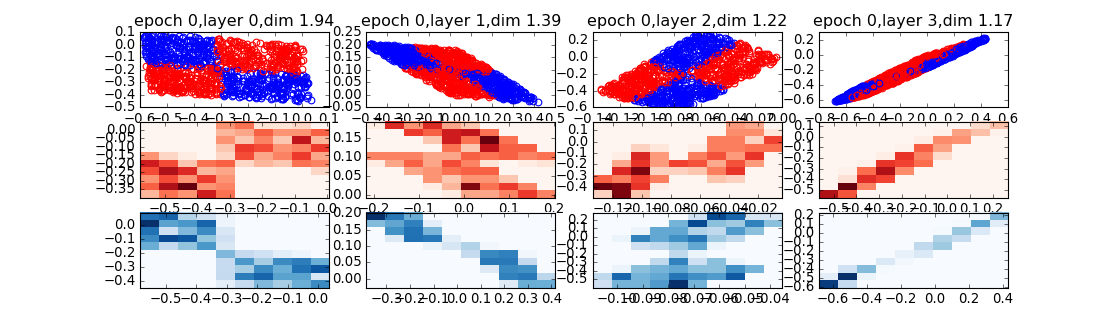

<IPython.core.display.Javascript object>


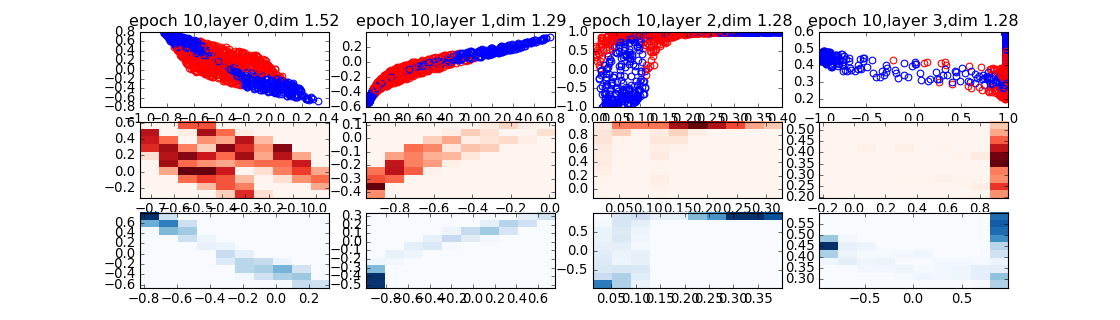

<IPython.core.display.Javascript object>


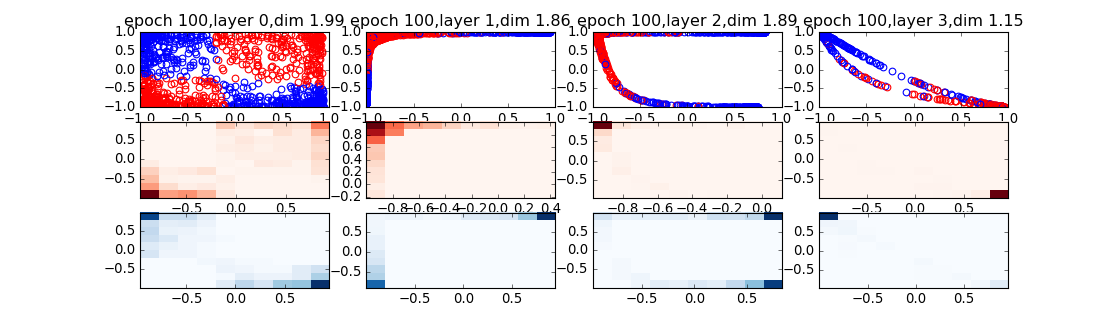

<IPython.core.display.Javascript object>


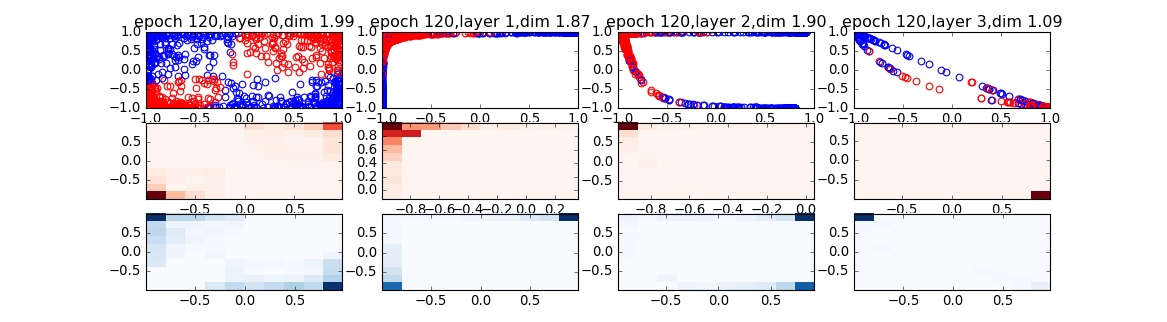

<IPython.core.display.Javascript object>


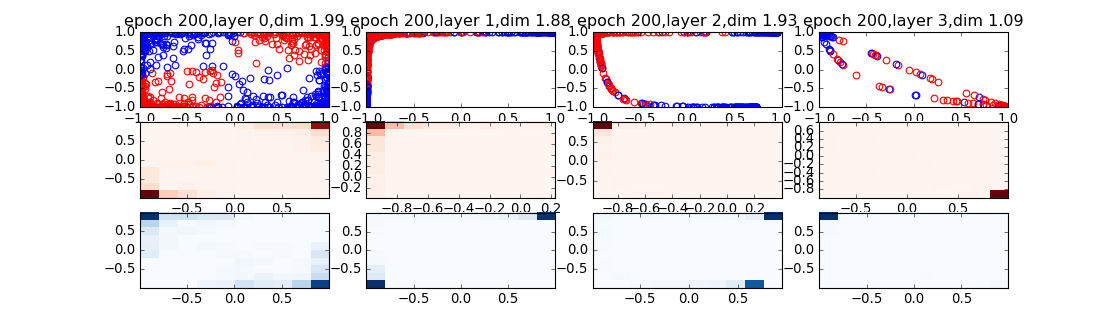

<IPython.core.display.Javascript object>


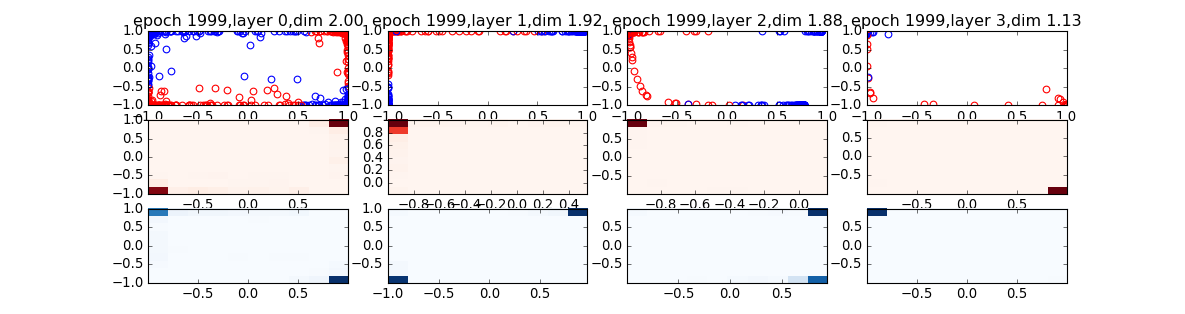

In [18]:
mx.random.seed(1)

batch_size = 10

net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(2, activation='tanh'))
    net.add(gluon.nn.Dense(2, activation='tanh'))
    net.add(gluon.nn.Dense(2, activation='tanh'))
    net.add(gluon.nn.Dense(2, activation='tanh'))
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=ctx)

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .1})

ndata = len(Y)
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X[:ndata/2, :], Y[:ndata/2]),
                                   batch_size=batch_size, shuffle=True)

def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

epochs = 2000

plot_epochs = [0, 10, 100, 120, 200, 1999]
smoothing_constant = .1

calc_epoch = 10
MIXs = np.zeros([epochs/calc_epoch, 4])
MIYs = np.zeros([epochs/calc_epoch, 4])
accs = np.zeros([epochs/calc_epoch])
idx = 0
for e in range(epochs):
    train_accuracy = evaluate_accuracy(train_data, net)
    
    if np.mod(e, calc_epoch) == 0:
        MIXs[idx, :], MIYs[idx, :] = calc_current_mi(net, X[:ndata/2, :], Y[:ndata/2], ngridX=4)
        accs[idx] = train_accuracy
        idx += 1
        
    if e in plot_epochs:
        plot_feature_map(net, X, Y, e)
        
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
            loss.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)

For calculating the mutual information, we turn the two dimensional space into grids and use the samples to estimate the probability of each grid.

The following figure shows the evolution of "accuracy", "mutual information between layers and input", "mutual information between layers and label" during the training process. 

<IPython.core.display.Javascript object>


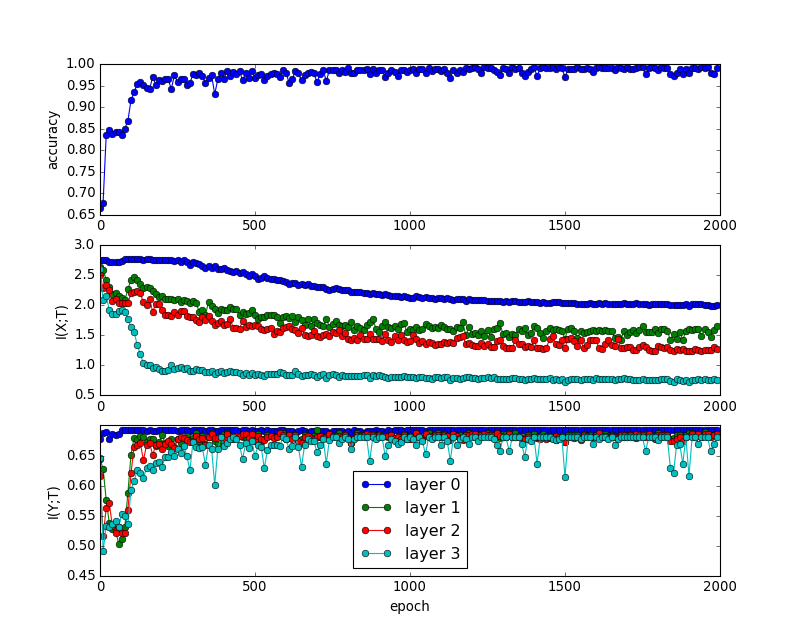

In [16]:
plt.figure(figsize=(10,8))
ax1 = plt.subplot(311)
plt.plot(np.arange(len(accs))*10, accs, 'o-')
plt.ylabel('accuracy')

# share x only
ax2 = plt.subplot(312, sharex=ax1)
for j in range(MIXs.shape[1]):
    plt.plot(np.arange(len(accs))*10, MIXs[:,j], 'o-', label='layer %d'%j)
# plt.legend(loc=0)
plt.ylabel('I(X;T)')

ax3 = plt.subplot(313, sharex=ax1)
for j in range(MIYs.shape[1]):
    plt.plot(np.arange(len(accs))*10, MIYs[:,j], 'o-', label='layer %d'%j)
plt.legend(loc=0)      
plt.ylabel('I(Y;T)')
plt.xlabel('epoch')
# MIXs, MIYs